# The effects of model complexity: overfitting and generalisation

[Previously](regression-nonlinear.ipynb) we have fit polynomial functions to regression data using the least squares and maximum likelihood approaches. In this section we will explore one of the problems with these estimation techniques: overfitting.

In [18]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

## Over and under-fitting

Returning to our simple 1D regression dataset, let's fit a polynomial model

$$\begin{align}
y_n = f_{\mathbf{w}}(x_n) + \sigma_y \epsilon_n = \sum_{d=0}^D w_d x^d_n + \sigma_y \epsilon_n \;\; \text{where} \;\; \epsilon \sim \mathcal{N}(0,1) 
\end{align}$$

and vary the order of the polynomial $D = 1, 2, ... 9$. Below are the resulting maximum likelihood fits of the underlying function $f_{\mathbf{w}}(x)$ shown in black:

In [79]:
# Load the same data that were used in the previous section
x_data = np.load('data/reg_nonlin_x.npy')
y_data = np.load('data/reg_nonlin_y.npy')

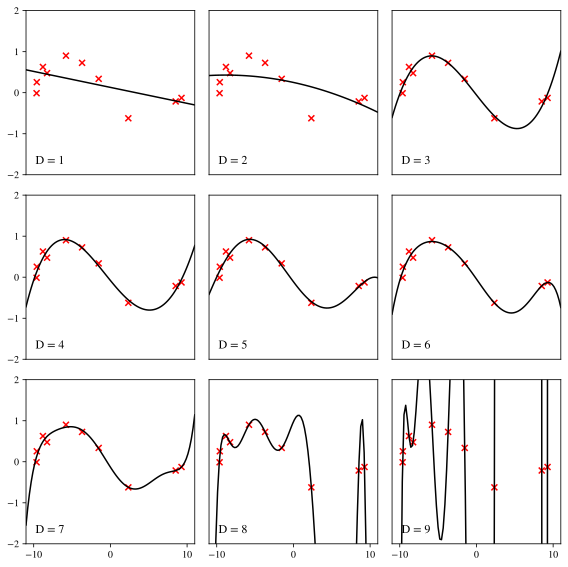

In [80]:
# 100 points equispaced between 0 and 1
x_plot = np.linspace(-11., 11., 100)

# Figure to plot models on
fig = plt.figure(figsize = (8, 8))

# Loop over different values of D, fit a different polynomial model for each
for D in range(1, 10):

    # Design matrix corresponding to the input data
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_data])
    
    # Solve for maximum-likelihood weights via Moore-Penrose pseudoinverse
    w = np.linalg.solve((phi.T).dot(phi) + 1e-16 * np.eye(D+1), (phi.T).dot(y_train))
    
    # As before, the line above is numerically stable version of
    # w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_data)
    
    # Design matrix at the prediction points
    phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_plot])
    
    # Mean model predictions
    y_plot = phi_pred.dot(w)
    
    # Plot data and predictions separately for each model
    plt.subplot(3, 3, D)
    
    plt.plot(x_plot, y_plot, color = 'black')
    plt.scatter(x_data, y_data, marker = 'x', color = 'red')
    
    # Format plots
    plt.text(
        x=-6.,
        y=-1.8,
        s=f'D = {D}',
        color='black',
        fontsize=12,
        horizontalalignment='right',
        verticalalignment='bottom'
    )
    
    plt.xlim([-11., 11.])
    plt.ylim([-2., 2.])
    
    if D % 3 is not 1:
        plt.yticks([])
    else:
        plt.yticks(np.linspace(-2., 2., 5))
        
    if D < 7:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(-10., 10., 3))
        
plt.tight_layout()
plt.show()

The plots show that, for low order polynomials, there is structure in the data which is not captured by the regression function. This is called *underfitting*. As the order of the polynomial increases, the model becomes more flexible and the fitted curve $f(x)$ can pass closer to each datapoint thereby reducing the cost function. Intermediate settings of $D$ lead to well fit models. The most complex model ($D = 9$) has $10$ degrees of freedom (including the constant $w_0$), which is equal to the number of datapoints. This provides the model with enough degrees of freedom for the polynomial to pass exactly through every data point achieving a cost of $0$. 

Although the $D=9$ solution has minimised our training cost, intuitively it looks poor. Do we really expect such an extreme polynomial to accurately predict unseen test data? This phenomenon is called *overfitting* and it is a serious problem that can occur when the model complexity becomes large compared to the amount of training data. Maximum likelihood fitting is particularly succeptible to this phenomenon. Overfitted models exhibit very small training errors but are too well adapted for the training data and *learn the noise* of that data too. Consequently, they make poor predictions about unseen datapoints $-$ they fail to generalise. 

## Training and validation sets

How can we automatically evaluate model performance and diagnose overfitting? One useful approach is to use only a subset of the data to train the model (the *training set*) leaving out a portion of the data to assess the fit (the *validation set*). The model's performance on the train and validation sets can be compared to diagnose overfitting: if predictions made on the training set are accurate, but those made on the test set are poor, it is likely that there is overfitting. Note that setting aside some data for validation does mean that there are fewer data to train on, potentially reducing the quality of the predictions. There are a wide range of refinements to this basic <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">**cross validation**</a> approach.

Let's use a validation set comprising 40 unseen data points to assess the quality of the models fit above.

In [85]:
x_data = np.load('data/reg_nonlin_x_extended.npy')
y_data = np.load('data/reg_nonlin_y_extended.npy')

# Split dataset into training and validation
x_train = x_data[:10]
y_train = y_data[:10]

x_valid = x_data[10:]
y_valid = y_data[10:]

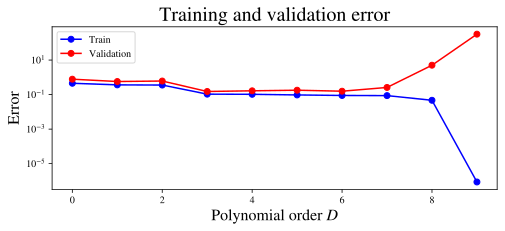

In [87]:
# Polynomial degree to go up to
Dmax = 9

# Lists to store training and validation error
train_err = []
valid_err = []

for D in range(Dmax + 1):
    
    # Design matrix at the training inputs
    phi = np.array([[x ** d for d in range(D + 1)] for x in x_train])
    
    # Solve for maximum-likelihood weights via Moore-Penrose pseudoinverse
    w = np.linalg.solve((phi.T).dot(phi), (phi.T).dot(y_train))

    # As before, the line above is numerically stable version of
    # w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_train)
    
    # Model predictions at validation data
    y_pred = phi.dot(w)
    
    # store train errors
    train_err.append(((y_pred - y_train) ** 2).mean() ** 0.5)
    
    # Design matrix at the prediction points
    phi_pred = np.array([[x ** d for d in range(D + 1)] for x in x_valid])
    
    # evaluate polynomial at test data points
    y_pred = phi_pred.dot(w)
    
    # Store validation error
    valid_err.append(((y_pred - y_valid)**2).mean()**0.5)

# Plot training error
plt.figure(figsize=(8, 3))
plt.plot(np.arange(0, Dmax+1),
         train_err,
         color='blue',
         marker='o',
         label='Train')

# Plot validation error
plt.plot(np.arange(0, Dmax+1),
         valid_err,
         color='red',
         marker='o',
         label='Validation')

# Format plot
plt.gca().legend()
plt.gca().set_yscale("log")
plt.title('Training and validation error', fontsize=20)
plt.xlabel('Polynomial order $D$', fontsize=16)
plt.ylabel('Error', fontsize=16)

plt.show()

As the order of the polynomial increases, the training error steadily decreases due to the model's increased flexibility, whereas the validation error initially decreases and then increases again. For low $D$ there is a small difference between train and validation errors indicating a small amount of overfitting. By $D=8$ the model has started to significantly overfit the training data and no longer makes sensible predictions on the validation set.

Note that when $D = 9$ training error shoots down. This is because a polynomial of degree $9$ has $10$ degrees of freedom, including the constant term. Since there are $10$ datapoints, when $D = 9$ the model has just enough degrees of freedom to fit the points exactly, and so the error shoots down.

```{admonition} A note on numerics
In the figure above, the error is not exactly zero for the ninth order polynomial. This is because of the numerical errors involved in the matrix inversions. These errors result in predictions which match the datapoints very closely but not precisely, resulting in a very small but non-zero prediction error.
```


## Summary

Overfitting occurs when a training procedure causes a model to capture aspects of the training data that are irrelevant or deleterious for predicting unseen test data.

Overfitting can be monitored by comparing the quality of predictions on the *training set* and a held-out *validation set*. A validation error that is much larger than the test error reveals overfitting.  

Having learned how to diagnose and quantify overfitting, in the next section we investigate how to use [regularisation](regression_regularisation.ipynb) to mitigate its effects.

## Questions

- Make a plot of the training and validation errors for a Gaussian basis function model. Instead of changing the number of basis functions, choose $D=10$ and alter the width of the basis function. Comment on the role of the width in the context of the complexity of the model. <br>

<details class="graydrop">
<summary>Answer</summary>
    
The width of the Gaussian basis function controls the typical length-scale over which the regression function changes. It therefore controls the flexibility of the model and with it the model's susceptibility to overfitting. Notice that for short length-scales, more basis functions may be required to obtain a sensible fit. 

</details>
<br>

- An experimenter uses a single validation set to evaluate i) many different choices of basis function $\phi_d(x)$, ii) many different orders of model $D$, and iii) many different hyper parameter settings e.g. $\sigma_{\mathbf{w}}$. They choose to use the model with the smallest validation error to make predictions on a test set. They are surprised that the resulting predictions are poor - after all they used a validation set to guard against overfitting. What has happened? How could they have improved their approach? <br> <br> Estimate how many Gaussian basis functions are required to fit these data. Think about the volume of space you will need to cover with basis functions and what the width and spacing of these functions will have to be.
    
<details class="graydrop">
<summary>Answer</summary>
    
The experimenter has overfit the _validation set_. If the validation set is used to decide amongst a very large set of models, it is perfectly possible to overfit at this second level model fitting. 
    
Approaches that might help in this case are i) <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation">k-fold cross validation</a> (which effective increases the size of the validation set), and ii) [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning) (averaging) model predictions rather than taking the best one. Another option would be to build a large model that contains the individual model as special cases and use Bayesian inference for fitting.
    
<br>
</details>